In [1]:
%%writefile large_batch_training.py

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import random_split
from google.colab import files

def compute_mean_std(dataset):
    """Compute the mean and std of CIFAR-100 dataset.

    Args:
        dataset: A dataset derived from `torch.utils.data.Dataset`,
                 such as `cifar100_training_dataset` or `cifar100_test_dataset`.

    Returns:
        A tuple containing (mean, std) for the entire dataset.
    """

    # Extract images and labels
    data_r = np.stack([np.array(dataset[i][0])[:, :, 0] for i in range(len(dataset))])
    data_g = np.stack([np.array(dataset[i][0])[:, :, 1] for i in range(len(dataset))])
    data_b = np.stack([np.array(dataset[i][0])[:, :, 2] for i in range(len(dataset))])

    # Compute mean and std
    mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std = np.std(data_r), np.std(data_g), np.std(data_b)

    return mean, std

# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model
net = LeNet5().to(device)

# Optimizer Subclasses
class LARS(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9, weight_decay=0, trust_coefficient=0.001):
        # Initialize the optimizer with the learning rate, momentum, weight decay, and trust coefficient
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, trust_coefficient=trust_coefficient)
        super(LARS, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it (commonly used for re-evaluating loss)
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                   # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                if len(state) == 0:
                    state['momentum_buffer'] = torch.clone(grad).detach()
                # Apply weight decay directly to the gradient
                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])
                # Compute the norms of the parameter and its gradient
                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(grad)
                # Compute local learning rate based on the trust coefficient and norms
                if param_norm > 0 and grad_norm > 0:
                    local_lr = group['trust_coefficient'] * param_norm / (grad_norm + 1e-8)
                    grad = grad.mul(local_lr) # Scale the gradient with the local learning rate
                # Update the momentum buffer
                momentum_buffer = state['momentum_buffer']
                momentum_buffer.mul_(group['momentum']).add_(grad) #Momentum update
                state['momentum_buffer'] = momentum_buffer
                # Update the parameter
                p.data.add_(momentum_buffer, alpha=-group['lr']) # Gradient descent step with learning rate
        return loss

class LAMB(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, betas=(0.9, 0.999), eps=1e-8):
        # Initialize the optimizer with learning rate, weight decay, betas for moment updates, and epsilon for stability
        defaults = dict(lr=lr, weight_decay=weight_decay, betas=betas, eps=eps)
        super(LAMB, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                # Initialize state
                if len(state) == 0:
                    # Initialize the state (step counter, first moment, second moment)
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data) # First moment (mean of gradients)
                    state['exp_avg_sq'] = torch.zeros_like(p.data) # Second moment (mean of squared gradients)
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']
                beta1, beta2 = group['betas']  # Coefficients for moment updates
                state['step'] += 1 # Increment step count
                step = state['step']
                # Decay the first and second moment running average coefficients
                # Update first and second moments
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1) # Exponential moving average of gradients
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2) # Exponential moving average of squared gradients
                # Correct bias in the first and second moments
                bias_correction1 = 1 - beta1 ** step
                bias_correction2 = 1 - beta2 ** step
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2
                # Compute the denominator for scaling the update
                denom = corrected_exp_avg_sq.sqrt().add_(group['eps']) # Stability epsilon
                # Compute the step update
                update = corrected_exp_avg / denom
                # Apply weight decay directly to the parameters
                if group['weight_decay'] != 0:
                    update.add_(p.data, alpha=group['weight_decay'])
                # Compute the trust ratio (norm of parameters vs norm of update)
                param_norm = torch.norm(p.data)
                update_norm = torch.norm(update)
                trust_ratio = 1.0  # Default trust ratio
                if param_norm > 0 and update_norm > 0:
                    trust_ratio = param_norm / update_norm
                # Update the parameters
                p.data.add_(update, alpha=-group['lr'] * trust_ratio)
        return loss

class SqrtLRScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, base_lr, batch_size, warmup_epochs, total_epochs, reference_batch_size, verbose=False):
        """
        Args:
            optimizer: PyTorch optimizer (e.g., Adam, LAMB, LARS).
            base_lr: Base learning rate for the reference batch size.
            batch_size: Current batch size.
            warmup_epochs: Number of warmup epochs.
            total_epochs: Total number of epochs.
            reference_batch_size: Batch size for which the base_lr is defined.
            verbose: Whether to print LR updates.
        """
        self.base_lr = base_lr
        self.batch_size = batch_size
        self.scaled_lr = base_lr * (batch_size / reference_batch_size) ** 0.5
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.verbose = verbose
        super(SqrtLRScheduler, self).__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            # Linear warmup scaling
            warmup_factor = (epoch + 1) / self.warmup_epochs
            return [warmup_factor * self.scaled_lr for _ in self.optimizer.param_groups]
        else:
            # polynomially decaying learning rate of ηt = η0×(1−t/T)
            if epoch == self.warmup_epochs:
                print(f"Warmup phase completed at epoch {epoch}. Switching to constant learning rate.")
            return [self.scaled_lr * ( 1 - ( (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs))) for _ in self.optimizer.param_groups]

# Command-line arguments
parser = argparse.ArgumentParser(description='Train with Large-Batch Optimizers')
parser.add_argument('--optimizer', type=str, default='SGDM', choices=['SGDM', 'AdamW', 'LARS', 'LAMB'],
                    help='Choose optimizer')
parser.add_argument('--batch-size', type=int, default=128, help='Batch size')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGDM and LARS')
parser.add_argument('--weight-decay', type=float, default=1e-5, help='Weight decay')
parser.add_argument('--b1', type=float, default=0.9, help='Beta1 for AdamW')
parser.add_argument('--b2', type=float, default=0.999, help='Beta2 for AdamW')
parser.add_argument('--trust-coefficient', type=float, default=0.001, help='Trust coefficient for LARS')
parser.add_argument('--epochs', type=int, default=150, help='Number of epochs')
parser.add_argument('--warmup-epochs', type=int, default=5, help='Number of epochs')
args = parser.parse_args()


torch.manual_seed(42) # Set the seed for reproducibility
torch.cuda.manual_seed_all(42) # Set the seed for reproducibility on GPU

# use the same mean and std to add consistency to all datasets
data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(data)

# Load and split CIFAR-100 dataset
train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  # transforms.RandomRotation(15),
  transforms.RandomCrop(32, padding=4),
  # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
  transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(), # Convert into tensor
    transforms.Normalize(mean, std)  # Normalization
])

test_transform = transforms.Compose([
    transforms.CenterCrop(24),
    transforms.Pad(4),
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=val_transform)
indices = torch.randperm(len(trainset))
val_size = int(0.2*len(trainset))
trainset = torch.utils.data.Subset(trainset, indices[:-val_size])
valset = torch.utils.data.Subset(valset, indices[-val_size:])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=args.batch_size, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=2)


# Fixed parameter from paper [18] to calculate the square root LR scaling value
# base_lr = 5 / (2**3 * 10**3)
# reference_batch_size = 512
#scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5

# Mapping optimizers
if args.optimizer == 'SGDM':
    base_lr = 1e-2
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.SGD(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'AdamW':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.AdamW(net.parameters(), lr=scaled_lr, betas=(args.b1, args.b2), weight_decay=args.weight_decay)
elif args.optimizer == 'LARS':
    base_lr = 1e-2
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LARS(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay, trust_coefficient=args.trust_coefficient)
elif args.optimizer == 'LAMB':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LAMB(net.parameters(), lr=scaled_lr, weight_decay=args.weight_decay)

criterion = nn.CrossEntropyLoss()

# scheduler should be e square root LR scaling rule and linear-epoch warmup scheduling to automatically adjust learning rate
scheduler = SqrtLRScheduler(
    optimizer = optimizer,
    base_lr = base_lr,
    batch_size = args.batch_size,
    warmup_epochs = args.warmup_epochs,
    total_epochs = args.epochs,
    reference_batch_size = reference_batch_size,
    verbose = True)

# Training Function
def train_model(optimizer, scheduler, model, criterion, trainloader, valloader , testloader, device, epochs, save_checkpoint_interval=10):
    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val, total_val, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
        val_loss /= len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct_val / total_val
        val_accuracies.append(val_accuracy)

        '''
        # Early Stopping
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1

        if epochs_no_improve == patience:
          print("Early stopping!")
          break
        '''

        # Test
        correct_test, total_test, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        test_accuracy = 100. * correct_test / total_test
        test_accuracies.append(test_accuracy)

        scheduler.step()

        # Checkpointing
        if (epoch + 1) % save_checkpoint_interval == 0:
            checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss.item(),
            }
            checkpoint_path = os.path.join('./', checkpoint_filename)
            torch.save(checkpoint, checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch + 1}: {checkpoint_path}')

            # Download the checkpoint
            files.download(checkpoint_filename)

        print(f'Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

# Train the model
print(f"--- Train with {args.optimizer} ---")
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = train_model(optimizer, scheduler, net, criterion, trainloader, valloader, testloader, device, args.epochs)

# Save model
torch.save(net.state_dict(), f'net_{args.optimizer}.pth')

# Plot results
# Plot Training Loss
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('train_loss.png')
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('train_accuracy.png')
plt.show()

# Plot Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(val_loss, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('val_loss.png')
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(6, 4))
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('val_accuracy.png')
plt.show()

# Plot Test Loss
plt.figure(figsize=(6, 4))
plt.plot(test_loss, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('test_loss.png')
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(6, 4))
plt.plot(test_acc, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('test_accuracy.png')
plt.show()

Writing large_batch_training.py


100%|██████████| 169M/169M [00:03<00:00, 42.6MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
--- Train with SGDM ---
Epoch 1/150, Train Acc: 1.29%, Val Acc: 1.48%, Test Acc: 1.73%
Epoch 1/150, Train Loss: 4.6056, Val Loss: 4.6031, Test Loss: 4.6039
Epoch 2/150, Train Acc: 1.76%, Val Acc: 2.76%, Test Acc: 2.44%
Epoch 2/150, Train Loss: 4.6016, Val Loss: 4.5945, Test Loss: 4.5954
Epoch 3/150, Train Acc: 2.05%, Val Acc: 2.51%, Test Acc: 2.58%
Epoch 3/150, Train Loss: 4.5820, Val Loss: 4.5363, Test Loss: 4.5430
Epoch 4/150, Train Acc: 3.18%, Val Acc: 5.41%, Test Acc: 5.40%
Epoch 4/150, Train Loss: 4.4664, Val Loss: 4.2185, Test Loss: 4.2487
Warmup phase completed at epoch 5. Switching to constant learning rate.
Epoch 5/150, Train Acc: 5.29%, Val Acc: 7.12%, Test Acc: 6.40%
Epoch 5/150, Train Loss: 4.2564, Val Loss: 4.1123, Test Loss: 4.1498
Epoch 6/150, Train Acc: 6.87%, Val Acc: 9.54%, Test Acc: 8.19%
Epoch 6/150, Tr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 10/150, Train Acc: 12.32%, Val Acc: 16.25%, Test Acc: 14.43%
Epoch 10/150, Train Loss: 3.7837, Val Loss: 3.5566, Test Loss: 3.6534
Epoch 11/150, Train Acc: 13.93%, Val Acc: 16.99%, Test Acc: 15.91%
Epoch 11/150, Train Loss: 3.6914, Val Loss: 3.4924, Test Loss: 3.5421
Epoch 12/150, Train Acc: 14.78%, Val Acc: 18.57%, Test Acc: 15.73%
Epoch 12/150, Train Loss: 3.6427, Val Loss: 3.4256, Test Loss: 3.5942
Epoch 13/150, Train Acc: 16.12%, Val Acc: 18.48%, Test Acc: 15.37%
Epoch 13/150, Train Loss: 3.5486, Val Loss: 3.4162, Test Loss: 3.5886
Epoch 14/150, Train Acc: 17.04%, Val Acc: 20.82%, Test Acc: 18.49%
Epoch 14/150, Train Loss: 3.5112, Val Loss: 3.3030, Test Loss: 3.4112
Epoch 15/150, Train Acc: 18.08%, Val Acc: 21.67%, Test Acc: 19.46%
Epoch 15/150, Train Loss: 3.4477, Val Loss: 3.2752, Test Loss: 3.3867
Epoch 16/150, Train Acc: 19.05%, Val Acc: 22.25%, Test Acc: 19.60%
Epoch 16/150, Train Loss: 3.3877, Val Loss: 3.2172, Test Loss: 3.3418
Epoch 17/150, Train Acc: 19.60%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 20/150, Train Acc: 22.15%, Val Acc: 27.43%, Test Acc: 23.86%
Epoch 20/150, Train Loss: 3.2074, Val Loss: 2.9809, Test Loss: 3.1380
Epoch 21/150, Train Acc: 23.82%, Val Acc: 27.44%, Test Acc: 22.84%
Epoch 21/150, Train Loss: 3.1305, Val Loss: 2.9623, Test Loss: 3.1767
Epoch 22/150, Train Acc: 23.36%, Val Acc: 28.28%, Test Acc: 23.46%
Epoch 22/150, Train Loss: 3.1168, Val Loss: 2.9065, Test Loss: 3.1318
Epoch 23/150, Train Acc: 24.30%, Val Acc: 29.37%, Test Acc: 24.92%
Epoch 23/150, Train Loss: 3.0934, Val Loss: 2.8646, Test Loss: 3.0359
Epoch 24/150, Train Acc: 24.94%, Val Acc: 30.15%, Test Acc: 26.09%
Epoch 24/150, Train Loss: 3.0442, Val Loss: 2.8208, Test Loss: 3.0209
Epoch 25/150, Train Acc: 27.09%, Val Acc: 30.50%, Test Acc: 26.50%
Epoch 25/150, Train Loss: 2.9570, Val Loss: 2.7887, Test Loss: 2.9871
Epoch 26/150, Train Acc: 27.37%, Val Acc: 31.64%, Test Acc: 25.73%
Epoch 26/150, Train Loss: 2.9335, Val Loss: 2.7453, Test Loss: 3.0355
Epoch 27/150, Train Acc: 28.13%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 30/150, Train Acc: 28.92%, Val Acc: 33.85%, Test Acc: 28.85%
Epoch 30/150, Train Loss: 2.8398, Val Loss: 2.6505, Test Loss: 2.8733
Epoch 31/150, Train Acc: 30.33%, Val Acc: 33.77%, Test Acc: 29.42%
Epoch 31/150, Train Loss: 2.7840, Val Loss: 2.6235, Test Loss: 2.8456
Epoch 32/150, Train Acc: 31.42%, Val Acc: 34.76%, Test Acc: 31.08%
Epoch 32/150, Train Loss: 2.7379, Val Loss: 2.5697, Test Loss: 2.7679
Epoch 33/150, Train Acc: 32.18%, Val Acc: 32.89%, Test Acc: 27.47%
Epoch 33/150, Train Loss: 2.6860, Val Loss: 2.6900, Test Loss: 2.9983
Epoch 34/150, Train Acc: 31.89%, Val Acc: 36.60%, Test Acc: 30.95%
Epoch 34/150, Train Loss: 2.7062, Val Loss: 2.5264, Test Loss: 2.7777
Epoch 35/150, Train Acc: 33.45%, Val Acc: 36.76%, Test Acc: 32.85%
Epoch 35/150, Train Loss: 2.6296, Val Loss: 2.5003, Test Loss: 2.6835
Epoch 36/150, Train Acc: 33.77%, Val Acc: 36.48%, Test Acc: 32.21%
Epoch 36/150, Train Loss: 2.6144, Val Loss: 2.4967, Test Loss: 2.7090
Epoch 37/150, Train Acc: 33.54%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 40/150, Train Acc: 35.25%, Val Acc: 37.04%, Test Acc: 33.64%
Epoch 40/150, Train Loss: 2.5414, Val Loss: 2.4550, Test Loss: 2.6294
Epoch 41/150, Train Acc: 35.82%, Val Acc: 37.26%, Test Acc: 32.37%
Epoch 41/150, Train Loss: 2.5098, Val Loss: 2.4491, Test Loss: 2.7040
Epoch 42/150, Train Acc: 35.94%, Val Acc: 38.13%, Test Acc: 33.85%
Epoch 42/150, Train Loss: 2.5010, Val Loss: 2.4127, Test Loss: 2.6583
Epoch 43/150, Train Acc: 36.73%, Val Acc: 38.16%, Test Acc: 32.14%
Epoch 43/150, Train Loss: 2.4611, Val Loss: 2.4088, Test Loss: 2.7144
Epoch 44/150, Train Acc: 36.81%, Val Acc: 38.75%, Test Acc: 34.04%
Epoch 44/150, Train Loss: 2.4630, Val Loss: 2.3820, Test Loss: 2.6104
Epoch 45/150, Train Acc: 37.34%, Val Acc: 39.04%, Test Acc: 33.42%
Epoch 45/150, Train Loss: 2.4289, Val Loss: 2.3858, Test Loss: 2.6628
Epoch 46/150, Train Acc: 38.03%, Val Acc: 39.99%, Test Acc: 35.40%
Epoch 46/150, Train Loss: 2.3963, Val Loss: 2.3294, Test Loss: 2.5651
Epoch 47/150, Train Acc: 38.32%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 50/150, Train Acc: 39.77%, Val Acc: 41.63%, Test Acc: 35.87%
Epoch 50/150, Train Loss: 2.3209, Val Loss: 2.2875, Test Loss: 2.5554
Epoch 51/150, Train Acc: 39.76%, Val Acc: 40.70%, Test Acc: 35.36%
Epoch 51/150, Train Loss: 2.3215, Val Loss: 2.2923, Test Loss: 2.5824
Epoch 52/150, Train Acc: 40.21%, Val Acc: 41.13%, Test Acc: 36.96%
Epoch 52/150, Train Loss: 2.2955, Val Loss: 2.2773, Test Loss: 2.4784
Epoch 53/150, Train Acc: 40.85%, Val Acc: 41.78%, Test Acc: 36.64%
Epoch 53/150, Train Loss: 2.2728, Val Loss: 2.2710, Test Loss: 2.4988
Epoch 54/150, Train Acc: 41.34%, Val Acc: 41.59%, Test Acc: 36.13%
Epoch 54/150, Train Loss: 2.2488, Val Loss: 2.2616, Test Loss: 2.5455
Epoch 55/150, Train Acc: 41.64%, Val Acc: 41.20%, Test Acc: 34.11%
Epoch 55/150, Train Loss: 2.2325, Val Loss: 2.2936, Test Loss: 2.6342
Epoch 56/150, Train Acc: 41.56%, Val Acc: 41.93%, Test Acc: 36.51%
Epoch 56/150, Train Loss: 2.2320, Val Loss: 2.2583, Test Loss: 2.5361
Epoch 57/150, Train Acc: 42.61%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 60/150, Train Acc: 43.08%, Val Acc: 42.84%, Test Acc: 37.05%
Epoch 60/150, Train Loss: 2.1615, Val Loss: 2.2062, Test Loss: 2.4884
Epoch 61/150, Train Acc: 43.71%, Val Acc: 43.20%, Test Acc: 38.23%
Epoch 61/150, Train Loss: 2.1390, Val Loss: 2.1889, Test Loss: 2.4410
Epoch 62/150, Train Acc: 43.51%, Val Acc: 42.28%, Test Acc: 36.25%
Epoch 62/150, Train Loss: 2.1432, Val Loss: 2.2457, Test Loss: 2.5373
Epoch 63/150, Train Acc: 43.03%, Val Acc: 43.40%, Test Acc: 37.35%
Epoch 63/150, Train Loss: 2.1605, Val Loss: 2.1779, Test Loss: 2.4756
Epoch 64/150, Train Acc: 44.31%, Val Acc: 42.94%, Test Acc: 37.75%
Epoch 64/150, Train Loss: 2.1046, Val Loss: 2.2068, Test Loss: 2.4432
Epoch 65/150, Train Acc: 44.45%, Val Acc: 43.30%, Test Acc: 37.91%
Epoch 65/150, Train Loss: 2.0959, Val Loss: 2.2100, Test Loss: 2.4723
Epoch 66/150, Train Acc: 44.79%, Val Acc: 44.00%, Test Acc: 38.05%
Epoch 66/150, Train Loss: 2.0970, Val Loss: 2.1743, Test Loss: 2.4340
Epoch 67/150, Train Acc: 44.73%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 70/150, Train Acc: 45.89%, Val Acc: 43.76%, Test Acc: 37.99%
Epoch 70/150, Train Loss: 2.0351, Val Loss: 2.2001, Test Loss: 2.4460
Epoch 71/150, Train Acc: 45.73%, Val Acc: 44.83%, Test Acc: 39.16%
Epoch 71/150, Train Loss: 2.0464, Val Loss: 2.1430, Test Loss: 2.4209
Epoch 72/150, Train Acc: 46.30%, Val Acc: 44.59%, Test Acc: 39.33%
Epoch 72/150, Train Loss: 2.0060, Val Loss: 2.1530, Test Loss: 2.4063
Epoch 73/150, Train Acc: 47.00%, Val Acc: 44.44%, Test Acc: 37.89%
Epoch 73/150, Train Loss: 1.9993, Val Loss: 2.1553, Test Loss: 2.4777
Epoch 74/150, Train Acc: 47.09%, Val Acc: 45.42%, Test Acc: 40.29%
Epoch 74/150, Train Loss: 1.9988, Val Loss: 2.1292, Test Loss: 2.3465
Epoch 75/150, Train Acc: 47.35%, Val Acc: 45.10%, Test Acc: 40.37%
Epoch 75/150, Train Loss: 1.9704, Val Loss: 2.1384, Test Loss: 2.3660
Epoch 76/150, Train Acc: 47.18%, Val Acc: 44.25%, Test Acc: 38.86%
Epoch 76/150, Train Loss: 1.9749, Val Loss: 2.1776, Test Loss: 2.3994
Epoch 77/150, Train Acc: 46.87%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 80/150, Train Acc: 48.13%, Val Acc: 45.63%, Test Acc: 39.12%
Epoch 80/150, Train Loss: 1.9320, Val Loss: 2.1194, Test Loss: 2.4267
Epoch 81/150, Train Acc: 48.06%, Val Acc: 45.46%, Test Acc: 39.47%
Epoch 81/150, Train Loss: 1.9253, Val Loss: 2.1228, Test Loss: 2.4148
Epoch 82/150, Train Acc: 48.84%, Val Acc: 45.50%, Test Acc: 39.43%
Epoch 82/150, Train Loss: 1.8980, Val Loss: 2.1143, Test Loss: 2.3919
Epoch 83/150, Train Acc: 48.99%, Val Acc: 45.74%, Test Acc: 40.80%
Epoch 83/150, Train Loss: 1.9016, Val Loss: 2.1128, Test Loss: 2.3515
Epoch 84/150, Train Acc: 48.47%, Val Acc: 45.02%, Test Acc: 38.88%
Epoch 84/150, Train Loss: 1.9055, Val Loss: 2.1248, Test Loss: 2.4360
Epoch 85/150, Train Acc: 49.14%, Val Acc: 45.58%, Test Acc: 40.43%
Epoch 85/150, Train Loss: 1.8844, Val Loss: 2.1082, Test Loss: 2.3428
Epoch 86/150, Train Acc: 49.37%, Val Acc: 46.87%, Test Acc: 40.03%
Epoch 86/150, Train Loss: 1.8722, Val Loss: 2.0708, Test Loss: 2.3729
Epoch 87/150, Train Acc: 49.50%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 90/150, Train Acc: 50.40%, Val Acc: 46.48%, Test Acc: 41.16%
Epoch 90/150, Train Loss: 1.8341, Val Loss: 2.0726, Test Loss: 2.3358
Epoch 91/150, Train Acc: 50.63%, Val Acc: 45.61%, Test Acc: 40.27%
Epoch 91/150, Train Loss: 1.8257, Val Loss: 2.1058, Test Loss: 2.3830
Epoch 92/150, Train Acc: 50.74%, Val Acc: 46.46%, Test Acc: 39.65%
Epoch 92/150, Train Loss: 1.8151, Val Loss: 2.0858, Test Loss: 2.3998
Epoch 93/150, Train Acc: 50.76%, Val Acc: 46.64%, Test Acc: 41.45%
Epoch 93/150, Train Loss: 1.8141, Val Loss: 2.0826, Test Loss: 2.3121
Epoch 94/150, Train Acc: 51.12%, Val Acc: 46.38%, Test Acc: 41.04%
Epoch 94/150, Train Loss: 1.8079, Val Loss: 2.0800, Test Loss: 2.3421
Epoch 95/150, Train Acc: 51.48%, Val Acc: 45.69%, Test Acc: 40.74%
Epoch 95/150, Train Loss: 1.7970, Val Loss: 2.1010, Test Loss: 2.3620
Epoch 96/150, Train Acc: 51.19%, Val Acc: 47.04%, Test Acc: 40.58%
Epoch 96/150, Train Loss: 1.7938, Val Loss: 2.0582, Test Loss: 2.3641
Epoch 97/150, Train Acc: 51.87%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 100/150, Train Acc: 52.15%, Val Acc: 46.33%, Test Acc: 41.50%
Epoch 100/150, Train Loss: 1.7553, Val Loss: 2.0903, Test Loss: 2.3157
Epoch 101/150, Train Acc: 52.27%, Val Acc: 46.89%, Test Acc: 41.95%
Epoch 101/150, Train Loss: 1.7433, Val Loss: 2.0640, Test Loss: 2.3118
Epoch 102/150, Train Acc: 52.84%, Val Acc: 47.03%, Test Acc: 41.68%
Epoch 102/150, Train Loss: 1.7354, Val Loss: 2.0568, Test Loss: 2.3254
Epoch 103/150, Train Acc: 52.60%, Val Acc: 46.84%, Test Acc: 41.40%
Epoch 103/150, Train Loss: 1.7290, Val Loss: 2.0767, Test Loss: 2.3118
Epoch 104/150, Train Acc: 52.94%, Val Acc: 47.39%, Test Acc: 41.63%
Epoch 104/150, Train Loss: 1.7268, Val Loss: 2.0668, Test Loss: 2.3604
Epoch 105/150, Train Acc: 52.98%, Val Acc: 47.98%, Test Acc: 40.94%
Epoch 105/150, Train Loss: 1.7240, Val Loss: 2.0396, Test Loss: 2.3525
Epoch 106/150, Train Acc: 53.44%, Val Acc: 47.79%, Test Acc: 41.96%
Epoch 106/150, Train Loss: 1.7062, Val Loss: 2.0394, Test Loss: 2.3141
Epoch 107/150, Train Acc: 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 110/150, Train Acc: 54.19%, Val Acc: 47.78%, Test Acc: 41.84%
Epoch 110/150, Train Loss: 1.6819, Val Loss: 2.0567, Test Loss: 2.3188
Epoch 111/150, Train Acc: 54.31%, Val Acc: 47.46%, Test Acc: 42.81%
Epoch 111/150, Train Loss: 1.6767, Val Loss: 2.0638, Test Loss: 2.2975
Epoch 112/150, Train Acc: 54.30%, Val Acc: 47.97%, Test Acc: 41.83%
Epoch 112/150, Train Loss: 1.6736, Val Loss: 2.0454, Test Loss: 2.2960
Epoch 113/150, Train Acc: 54.34%, Val Acc: 47.94%, Test Acc: 42.31%
Epoch 113/150, Train Loss: 1.6650, Val Loss: 2.0316, Test Loss: 2.3006
Epoch 114/150, Train Acc: 54.53%, Val Acc: 47.59%, Test Acc: 41.80%
Epoch 114/150, Train Loss: 1.6545, Val Loss: 2.0350, Test Loss: 2.3204
Epoch 115/150, Train Acc: 55.23%, Val Acc: 48.06%, Test Acc: 41.70%
Epoch 115/150, Train Loss: 1.6290, Val Loss: 2.0375, Test Loss: 2.3216
Epoch 116/150, Train Acc: 54.98%, Val Acc: 47.90%, Test Acc: 41.81%
Epoch 116/150, Train Loss: 1.6396, Val Loss: 2.0424, Test Loss: 2.3014
Epoch 117/150, Train Acc: 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 120/150, Train Acc: 55.85%, Val Acc: 48.13%, Test Acc: 42.64%
Epoch 120/150, Train Loss: 1.6114, Val Loss: 2.0278, Test Loss: 2.2695
Epoch 121/150, Train Acc: 55.56%, Val Acc: 48.47%, Test Acc: 42.48%
Epoch 121/150, Train Loss: 1.6159, Val Loss: 2.0319, Test Loss: 2.2992
Epoch 122/150, Train Acc: 55.66%, Val Acc: 48.12%, Test Acc: 42.15%
Epoch 122/150, Train Loss: 1.6089, Val Loss: 2.0262, Test Loss: 2.2988
Epoch 123/150, Train Acc: 55.94%, Val Acc: 48.93%, Test Acc: 42.33%
Epoch 123/150, Train Loss: 1.5986, Val Loss: 2.0187, Test Loss: 2.3029
Epoch 124/150, Train Acc: 55.94%, Val Acc: 48.43%, Test Acc: 42.69%
Epoch 124/150, Train Loss: 1.5987, Val Loss: 2.0246, Test Loss: 2.2921
Epoch 125/150, Train Acc: 55.90%, Val Acc: 48.30%, Test Acc: 41.94%
Epoch 125/150, Train Loss: 1.5964, Val Loss: 2.0290, Test Loss: 2.3116
Epoch 126/150, Train Acc: 56.16%, Val Acc: 48.70%, Test Acc: 42.46%
Epoch 126/150, Train Loss: 1.5989, Val Loss: 2.0312, Test Loss: 2.2801
Epoch 127/150, Train Acc: 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 130/150, Train Acc: 56.54%, Val Acc: 48.72%, Test Acc: 42.71%
Epoch 130/150, Train Loss: 1.5585, Val Loss: 2.0142, Test Loss: 2.2830
Epoch 131/150, Train Acc: 56.84%, Val Acc: 48.92%, Test Acc: 42.90%
Epoch 131/150, Train Loss: 1.5638, Val Loss: 2.0085, Test Loss: 2.2802
Epoch 132/150, Train Acc: 57.19%, Val Acc: 48.60%, Test Acc: 43.11%
Epoch 132/150, Train Loss: 1.5426, Val Loss: 2.0261, Test Loss: 2.2979
Epoch 133/150, Train Acc: 57.12%, Val Acc: 49.00%, Test Acc: 43.41%
Epoch 133/150, Train Loss: 1.5458, Val Loss: 2.0162, Test Loss: 2.2687
Epoch 134/150, Train Acc: 57.09%, Val Acc: 49.19%, Test Acc: 42.81%
Epoch 134/150, Train Loss: 1.5455, Val Loss: 2.0072, Test Loss: 2.2883
Epoch 135/150, Train Acc: 57.50%, Val Acc: 48.98%, Test Acc: 43.18%
Epoch 135/150, Train Loss: 1.5423, Val Loss: 2.0061, Test Loss: 2.2727
Epoch 136/150, Train Acc: 57.44%, Val Acc: 48.92%, Test Acc: 43.47%
Epoch 136/150, Train Loss: 1.5285, Val Loss: 2.0100, Test Loss: 2.2583
Epoch 137/150, Train Acc: 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 140/150, Train Acc: 58.20%, Val Acc: 49.19%, Test Acc: 43.11%
Epoch 140/150, Train Loss: 1.5114, Val Loss: 2.0095, Test Loss: 2.2714
Epoch 141/150, Train Acc: 58.21%, Val Acc: 49.43%, Test Acc: 43.16%
Epoch 141/150, Train Loss: 1.5171, Val Loss: 2.0077, Test Loss: 2.2717
Epoch 142/150, Train Acc: 58.28%, Val Acc: 49.15%, Test Acc: 43.37%
Epoch 142/150, Train Loss: 1.5060, Val Loss: 2.0044, Test Loss: 2.2608
Epoch 143/150, Train Acc: 58.38%, Val Acc: 49.23%, Test Acc: 43.74%
Epoch 143/150, Train Loss: 1.5035, Val Loss: 1.9994, Test Loss: 2.2663
Epoch 144/150, Train Acc: 58.55%, Val Acc: 49.27%, Test Acc: 43.37%
Epoch 144/150, Train Loss: 1.4942, Val Loss: 2.0018, Test Loss: 2.2670
Epoch 145/150, Train Acc: 58.54%, Val Acc: 49.44%, Test Acc: 43.47%
Epoch 145/150, Train Loss: 1.4960, Val Loss: 1.9969, Test Loss: 2.2729
Epoch 146/150, Train Acc: 58.84%, Val Acc: 49.60%, Test Acc: 43.46%
Epoch 146/150, Train Loss: 1.4917, Val Loss: 1.9931, Test Loss: 2.2741
Epoch 147/150, Train Acc: 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 150/150, Train Acc: 58.78%, Val Acc: 49.39%, Test Acc: 43.70%
Epoch 150/150, Train Loss: 1.4884, Val Loss: 1.9942, Test Loss: 2.2679


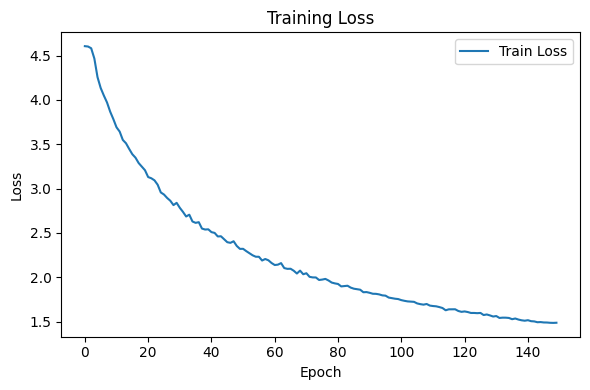

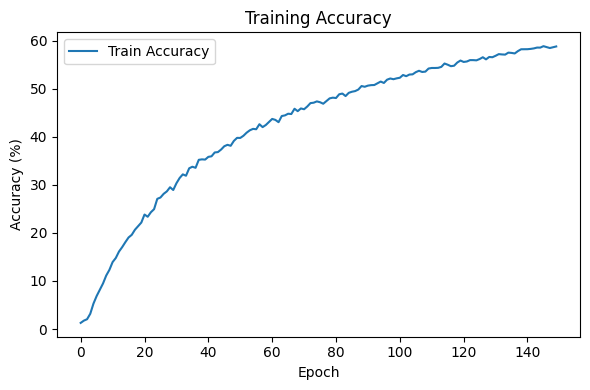

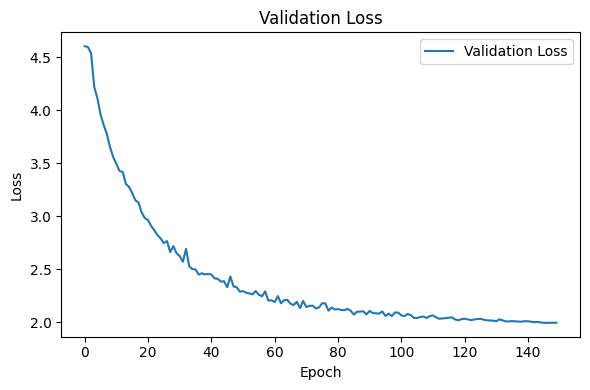

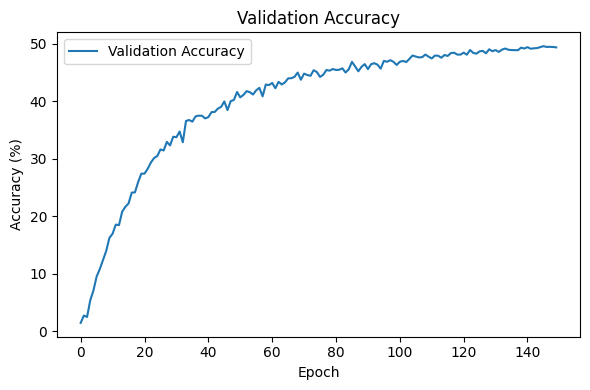

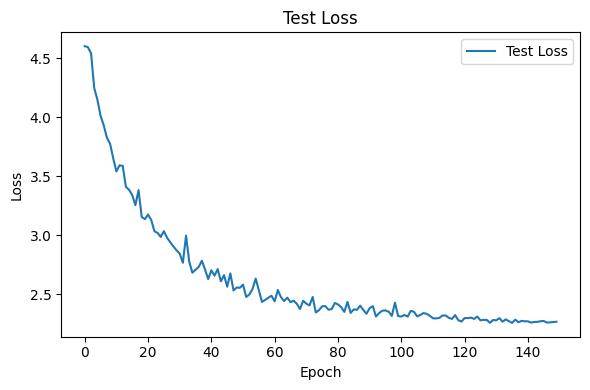

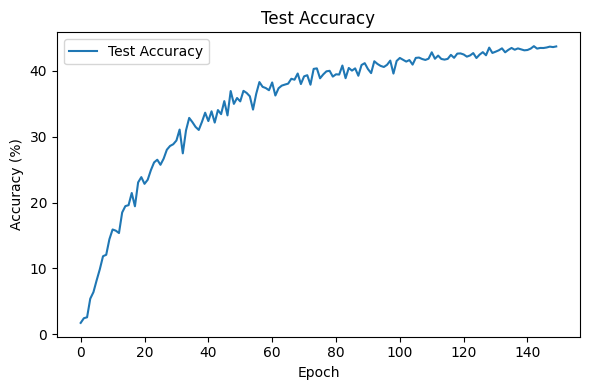

<Figure size 640x480 with 0 Axes>

In [2]:
%run large_batch_training.py --optimizer SGDM --batch-size 2048 --momentum 0.9 --weight-decay 4e-4 --epochs 150 --warmup-epochs 5

